# **Gru Prediction model**
Este notebook vai ser dividido da seguinte forma:\
-Data load\
-Data Preparation\
-Build Gru\
-Fit Gru\
-Forecast Predictions\

### **Data Loading**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

Em baixo temos o formato do dataset original, como carregamos o dataset atravez da página web do mesmo, garantimos que todos os dias temos a versão mais atualizada dos dados

In [2]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,853,853,854,854,855,855,855,855,855,855
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,140,142,148,155,166,172,176,183,186,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,661,662,671,683,688,693,698,698,702,707
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,728,844,885,902,909,919,922,941,967,992
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,176,176,197,197,210,210,247,247,247,265
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,5035,5097,5160,5221,5279,5338,5399,5457,5513,5567


### **Data Preparation**
Para se preparar os dados para alimentar a nossa rede neuronal recorrente, cada linha do dataset corresponde a um dia (timestep), e cada coluna corresponde a uma contagem, como se segue:\
-Total_Cases\
-Weekday\
-Daily_Cases\
-Daily_Deaths
-Total_Deaths\
-Total_Recoveries\
-Days_Gone\

In [3]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        if(country == "World Wide"):
            self.PreparaDataGlobal()
        else:
            self.PreparaData()
        fator=18 # Número de dias que se corrige
        self.CorrigirCasosNegativos(fator,self.new_dataset) 
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        daily_deaths=[]
        daily_cases=[]
        day_of_week=[]
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            day_of_week.append(current_date.weekday())
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
            daily_cases.append(self.confirmed[cols].sum()-sum(daily_cases))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
            daily_deaths.append(self.deaths[cols].sum()-sum(daily_deaths))
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['WeekDay'] = day_of_week
        self.new_dataset['Daily_Cases'] = daily_cases
        self.new_dataset['Daily_Deaths'] = daily_deaths
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        
    def PreparaDataGlobal(self):
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
    
    def CorrigirCasosNegativos(self,fator,df):
        for index,row in df.iterrows():
            if(row['Daily_Cases']<0):
                df.loc[index-fator:index,'Daily_Cases']=df.loc[index-fator:index,'Daily_Cases'].sub(int(abs(row['Daily_Cases'])/fator))
                df.loc[index-fator:index,'Total_Cases']=df.loc[index-fator:index,'Total_Cases'].sub(int(abs(row['Daily_Cases'])/fator))
                row['Daily_Cases']=int(abs(row['Daily_Cases'])/fator)
        self.new_dataset = df



### **Feeding daily increase Gru**
Para alimentar a nossa rede Gru, são dados 15 timesteps que correspondem a 15 dias individuas e em sequencia temporal.\
O seguinte modelo Gru, que preve o aumento de casos diarios utiliza duas features como input, o dialy_cases e o weekday e fornece como output a previsão de incremento de casos diarios do 16º dia.\
Já dentro da nossa classe Gru, todos os dados vão ser normalizados automaticamente, sendo que no fim os outputs vão ser desnormalizados de modo a facilitar a compreensao dos dados obtidos.\
O treino ideal para este modelo é de cerca de 250 epócas com base na análise dos gráficos de loss e validation_loss.

In [15]:
class GRU():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=2
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:3])
                self.Y.append(self.normalized[input_index:label_index,2])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.GRU(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.GRU(64, return_sequences=True))
        self.model.add(keras.layers.GRU(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))

    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("model.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=250,batch_size = 7,validation_split=0.05,shuffle=False,verbose=False)
        self.model.save_weights("model.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=False)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][2])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=False)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][2] = yhat
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')
        
        
        #-------------------------------------------------Second Graph---------------------------------------------------
        
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Daily Corona Cases ', fontsize=15, color='#0c3c6e')

        plt.xlabel('Day', fontsize=10)
        plt.ylabel('Cases per day', fontsize=10)
        
        DenormalizedData = pd.read_csv('Dados/new_dataset.csv')
        
        DenormalizedData=DenormalizedData[DenormalizedData['Total_Cases']>0]
        
        df_values = pd.DataFrame()
        df_values['CasosDiarios']=DenormalizedData['Daily_Cases']
        
        df_values = df_values.reset_index()
        df_values = df_values.drop(['index'],axis=1)

        ax.bar(df_values.index,df_values[:]['CasosDiarios'],label='Real')
        last_index = df_values.index[-1] + 1
        index = []
        for i in range(len(prediction)):
            index.append(i+last_index)
        ax.bar(index,prediction,label='Previsão')
        ax.grid()
        #fig.savefig('static/Casos_diarios.png')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.show()

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = res
            Denormalized[0][3] = -1
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][2])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

### **Feeding Death prediction Gru**
Para alimentar a nossa rede Gru de previsão de mortes diarias, são dados 15 timesteps que correspondem a 15 dias individuas e em sequencia temporal.\
O seguinte modelo Gru, que preve o aumento de mortes registadas diarimente utiliza três features como input, o dialy_cases, daily_deaths e o weekday e fornece como output a previsão de incremento de mortes diarios do 16º dia.\
O ponto ideal de treino desta rede é por volta das 150 epócas.

In [16]:
class GRUDeaths():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=3
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,1:4])
                self.Y.append(self.normalized[input_index:label_index,3])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.X_test = self.X[-10:]
        self.Y_test = self.Y[-10:]
        self.X = self.X[:-10]
        self.Y = self.Y[:-10]
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.GRU(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.GRU(64, return_sequences=True))
        self.model.add(keras.layers.GRU(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(1, activation="linear"))
    
        
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        try:
            self.model.load_weights("modelDeaths.h5")
        except:
            print('Model not found')
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,batch_size = 4,validation_split=0.05,shuffle=False)
        self.model.save_weights("modelDeaths.h5")
    def PredictTest(self,data):
        result = self.model.predict(data,verbose=True)
        print(result)
        results = []
        for res in result:
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            results.append(value[0][3])
        return results
    
    def Predict(self,data):
        result = self.model.predict(data,verbose=True)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,1:3]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,2)
            
            taxa_Erro = random.uniform(-0.005,0.005 )

            yhat=self.Predict(inp) + taxa_Erro
            
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = inp[0][inp.shape[1]-1][1]
            Denormalized[0][3] = yhat
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][2])
            #predictions.append(yhat[0][0])
            newCase = np.array((float(yhat),inp[0][inp.shape[1]-7][1]))  #
            inp = np.append(inp, newCase)
            inp = np.reshape(inp,(-1,2))
            inp=inp[-timesteps:,:]
            #print(inp)
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        new_pred = []
        verificador = 0
        for pred in prediction:
            if(verificador == 0):  
                new_pred.append(self.df['Total_Cases'].iloc[-1] + int(pred))
                verificador = 1
            else:
                new_pred.append(new_pred[-1] + int(pred))
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontweight='bold',fontsize=30, color='#0c3c6e')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(new_pred)),(new_pred), label='50 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
              
        ax.grid()
        #fig.savefig('static/lstm.png')

    def barplot(self,predictions):
        teste = []
        for res in self.Y_test.flatten():
            Denormalized = np.ndarray((1,7))
            Denormalized[0][0] = -1
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = res
            Denormalized[0][4] = -1
            Denormalized[0][5] = -1
            Denormalized[0][6] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            teste.append(value[0][3])
        
        df = pd.DataFrame({'Actual': teste, 'Predicted': np.asarray(predictions).flatten()})

        df1 = df.head(25)
        df1.plot(kind='bar',figsize=(16,10))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        
    def PlotLoss(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        print(self.model.history.history.keys())
        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('loss vs val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss'], loc='upper left')
        plt.show()

## Country Selection
Na celula seguinte, o valor do atributo country indica para qual pais o dataset vai ser preparado, portanto caso se pretenda fazer pevisões para qualquer país no mundo, apenas se precisa de trocar o próximo campo

In [17]:
country = "Brazil"
data = Data(country)


### Dataset Final
O dataset preparado para alimentar a nossa rede neuronal encontra-se na célula abaixo.\
É importante denotar que a rede não ira treinar com todas as colunas do dataset e dependendo do tipo de modelo ou previsão irão ser utilizadas colunas distintas
O dataset corresponde ao país selecionado no atributo 'country'

In [18]:
data.new_dataset

,Total_Cases,WeekDay,Daily_Cases,Daily_Deaths,Total_Recovered,Total_Deaths,Days_Gone
0,0,2,0,0,0,0,22
1,0,3,0,0,0,0,23
2,0,4,0,0,0,0,24
3,0,5,0,0,0,0,25
4,0,6,0,0,0,0,26
...,...,...,...,...,...,...,...
149,1032913,4,54771,1206,551631,48954,171
150,1067579,5,34666,1022,576779,49976,172
151,1083341,6,15762,615,588118,50591,173
152,1106470,0,23129,680,601736,51271,174


## Treino e análise dos gráficos
Na celula em baixo tem representado um gráfico que mostra os valores de loss e val_loss do nosso modelo, sendo que a partir dele consegue-se perceber a necessidade de mais ou menos treino 

Model not found
dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


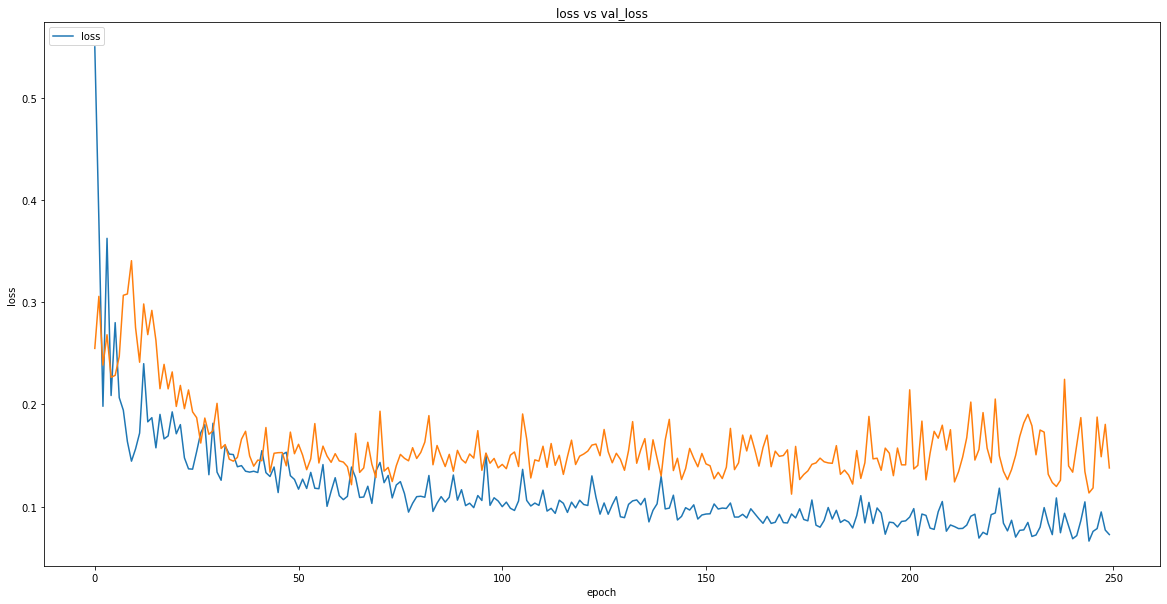

In [19]:
gru = GRU()
gru.PlotLoss()

## Avaliação da rede
Na celula seguinte, temos a avaliação da rede, no entanto importante realçar que devido ao pequeno tamanho da base de dados, as partições de teste, assim como as de validação são um pouco pequenas, o que pode representar valores de avaliação um pouco imprecisos, ou seja, caso os dados de teste fossem maiores, é provavel que estes valores melhorassem pois iam ser mais representativos da verdadeira perfomance do modelo

In [20]:
results = gru.model.evaluate(gru.X_test,gru.Y_test)


10/10 [==============================] - 4s 359ms/sample - loss: 0.3485 - mae: 0.2792 - RMSE: 0.3485


### **Predictions**
Na celula em baixo, vamos utilizar o dataset de teste para efetuar previsões e analisar com o valor real e perceber a qualidade do nosso modelo, o dataset de teste corresponde a dados de uma semana completa do país escolhido.
Como se pode analisar, as previsões são bastante precisas face ao número real, com excepção de um dos dias em que ocorreu um grande pico no número de casos, como é natural, a rede não conseguiu prever este pico.

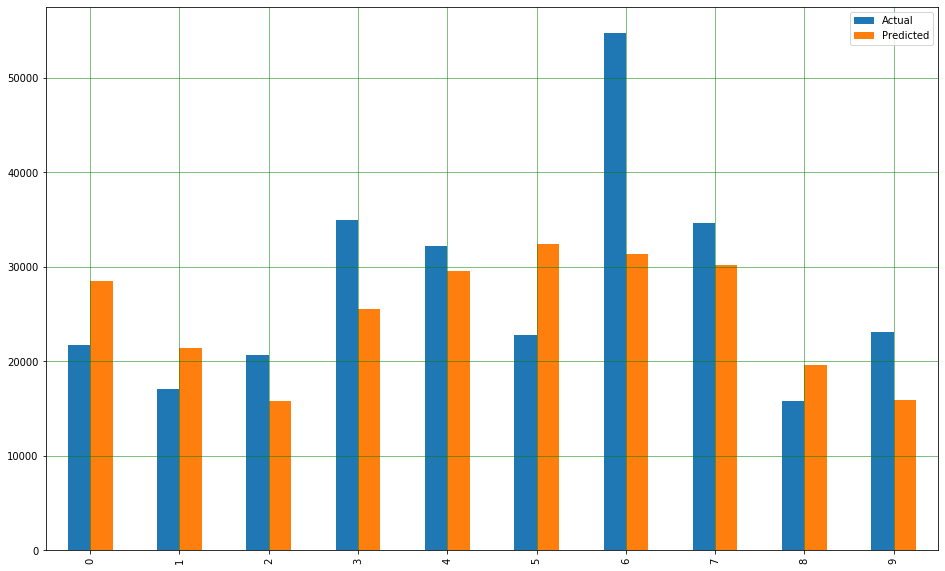

In [21]:
preds = gru.PredictTest(gru.X_test)
gru.barplot(preds)
#lstm.forecast()

### **Forecasting the future**
Para prever o futuro, alimentamos os últimos 15 dias para prever o dia seguinte, depois o dia previsto é adicionado ao conjunto de dados e o dia seguinte é previsto usando os últimos 15 dias correspondentes. \
Após 15 previsões, a rede está a usar as suas próprias previsões para prever. Isto pode causar com que o erro aumente, mas dessa forma podemos cavaliar de um modo muito mais interessante a evolução de cada país. 
Os gráficos abaixo mostra os números previstos para o pais introduzido no atributo 'Country' para os próximos 50 dias. Para prever outros países, basta alterar a variável "country".
É interessante notar no segundo gráfico que o incremento de casos baixao durante o fim de semana, entao a rede aprende este fator e consegue reduzir corretamente o numero de casos previstos ao fim de semana

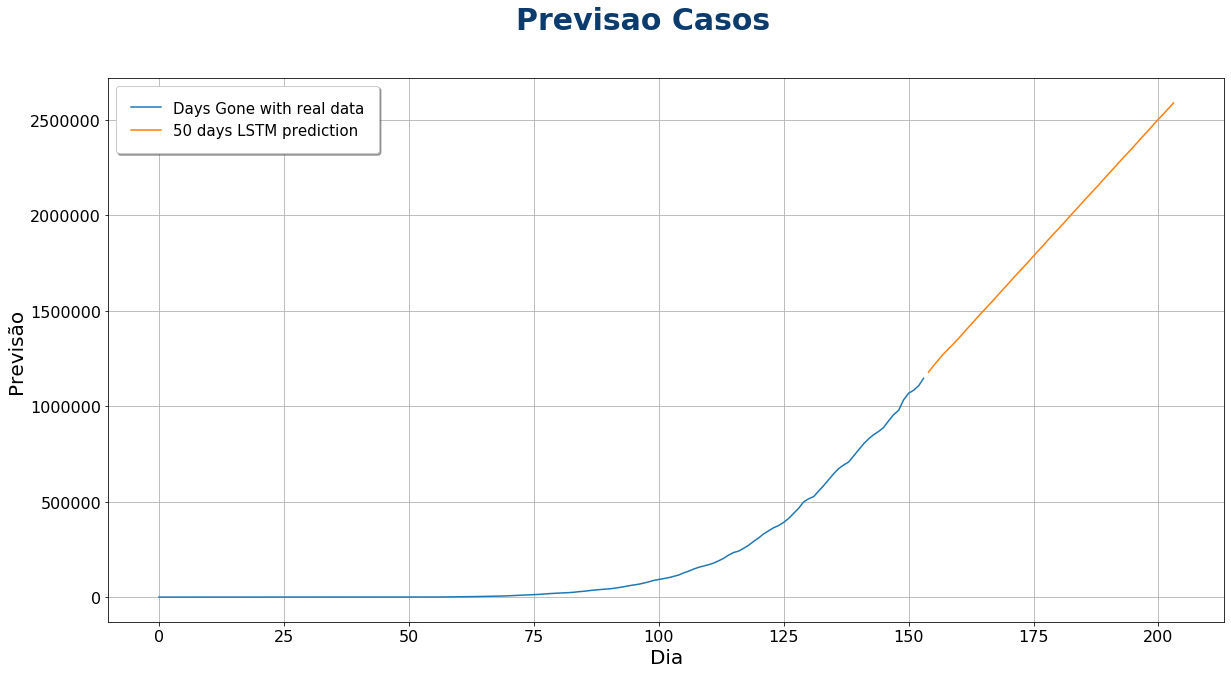

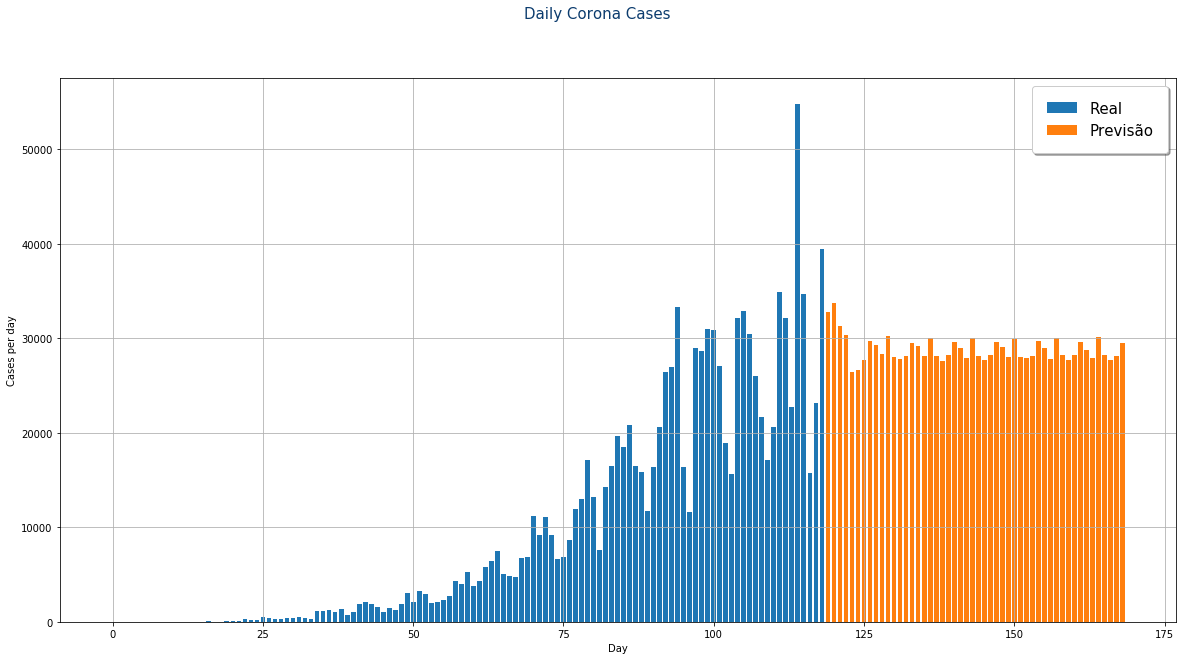

In [22]:
gru.forecast()

## Modelo de previsão de mortes

In [23]:
gruDeaths = GRUDeaths()

Model not found
Train on 121 samples, validate on 7 samples
Epoch 1/150
121/121 [==============================] - 8s 64ms/sample - loss: 0.4742 - mae: 0.4496 - RMSE: 0.4714 - val_loss: 0.4826 - val_mae: 0.4199 - val_RMSE: 0.4950
Epoch 2/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.5923 - mae: 0.5730 - RMSE: 0.5834 - val_loss: 0.4323 - val_mae: 0.3637 - val_RMSE: 0.4356
Epoch 3/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.2646 - mae: 0.2382 - RMSE: 0.2615 - val_loss: 0.4072 - val_mae: 0.3793 - val_RMSE: 0.3945
Epoch 4/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.4058 - mae: 0.3780 - RMSE: 0.3961 - val_loss: 0.4010 - val_mae: 0.3648 - val_RMSE: 0.3929
Epoch 5/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.3726 - mae: 0.3480 - RMSE: 0.3665 - val_loss: 0.3983 - val_mae: 0.3744 - val_RMSE: 0.3833
Epoch 6/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.3169 - mae: 0.2

Epoch 49/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1409 - mae: 0.1191 - RMSE: 0.1385 - val_loss: 0.1318 - val_mae: 0.1190 - val_RMSE: 0.1309
Epoch 50/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1407 - mae: 0.1217 - RMSE: 0.1408 - val_loss: 0.1668 - val_mae: 0.1340 - val_RMSE: 0.1684
Epoch 51/150
121/121 [==============================] - 0s 4ms/sample - loss: 0.1841 - mae: 0.1577 - RMSE: 0.1854 - val_loss: 0.1506 - val_mae: 0.1375 - val_RMSE: 0.1468
Epoch 52/150
121/121 [==============================] - 0s 4ms/sample - loss: 0.1914 - mae: 0.1616 - RMSE: 0.1872 - val_loss: 0.1946 - val_mae: 0.1578 - val_RMSE: 0.1939
Epoch 53/150
121/121 [==============================] - 0s 4ms/sample - loss: 0.1886 - mae: 0.1643 - RMSE: 0.1910 - val_loss: 0.2082 - val_mae: 0.1808 - val_RMSE: 0.2111
Epoch 54/150
121/121 [==============================] - 0s 4ms/sample - loss: 0.2005 - mae: 0.1842 - RMSE: 0.1987 - val_loss: 0.1615 - val_mae: 0.1461

121/121 [==============================] - 0s 3ms/sample - loss: 0.1256 - mae: 0.1097 - RMSE: 0.1335 - val_loss: 0.1785 - val_mae: 0.1528 - val_RMSE: 0.1859
Epoch 98/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1593 - mae: 0.1399 - RMSE: 0.1569 - val_loss: 0.1808 - val_mae: 0.1498 - val_RMSE: 0.1859
Epoch 99/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1535 - mae: 0.1334 - RMSE: 0.1628 - val_loss: 0.1606 - val_mae: 0.1363 - val_RMSE: 0.1713
Epoch 100/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1783 - mae: 0.1548 - RMSE: 0.1740 - val_loss: 0.2440 - val_mae: 0.2016 - val_RMSE: 0.2488
Epoch 101/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1914 - mae: 0.1704 - RMSE: 0.1882 - val_loss: 0.1667 - val_mae: 0.1562 - val_RMSE: 0.1668
Epoch 102/150
121/121 [==============================] - 0s 4ms/sample - loss: 0.1413 - mae: 0.1186 - RMSE: 0.1393 - val_loss: 0.1542 - val_mae: 0.1419 - val_RMS

121/121 [==============================] - 0s 3ms/sample - loss: 0.1671 - mae: 0.1487 - RMSE: 0.1641 - val_loss: 0.1528 - val_mae: 0.1350 - val_RMSE: 0.1568
Epoch 146/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1446 - mae: 0.1273 - RMSE: 0.1416 - val_loss: 0.1406 - val_mae: 0.1094 - val_RMSE: 0.1433
Epoch 147/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1703 - mae: 0.1524 - RMSE: 0.1740 - val_loss: 0.1474 - val_mae: 0.1124 - val_RMSE: 0.1514
Epoch 148/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1843 - mae: 0.1614 - RMSE: 0.1867 - val_loss: 0.2170 - val_mae: 0.1761 - val_RMSE: 0.2204
Epoch 149/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1561 - mae: 0.1397 - RMSE: 0.1573 - val_loss: 0.1689 - val_mae: 0.1504 - val_RMSE: 0.1748
Epoch 150/150
121/121 [==============================] - 0s 3ms/sample - loss: 0.1244 - mae: 0.1085 - RMSE: 0.1254 - val_loss: 0.1329 - val_mae: 0.1162 - val_R

Na celula seguinte pode-se analisar os gráficos de loss e val_loss do nosso modelo e como se pode analisar, por volta da epóca 150 o modelo ja não estava a melhorar

dict_keys(['loss', 'mae', 'RMSE', 'val_loss', 'val_mae', 'val_RMSE'])


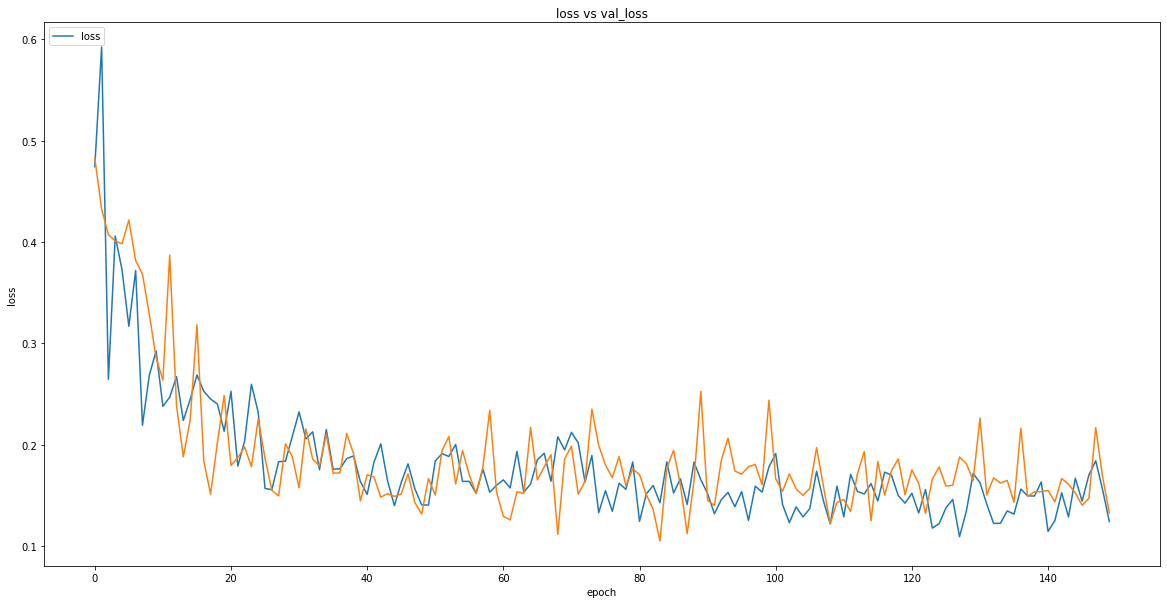

In [24]:
gruDeaths.PlotLoss()

## Análise de previsões
No gráfico seguinte podemos ver as previsões em o dataset de teste, como se pode analisar os resultados são bastante promissores

10/10 [==============================] - 1s 123ms/sample
[[ 0.2726354 ]
 [-0.21682334]
 [-0.04410964]
 [ 0.59324664]
 [ 0.6214159 ]
 [ 0.75534123]
 [ 0.53809375]
 [ 0.35480064]
 [-0.3564632 ]
 [ 0.065393  ]]


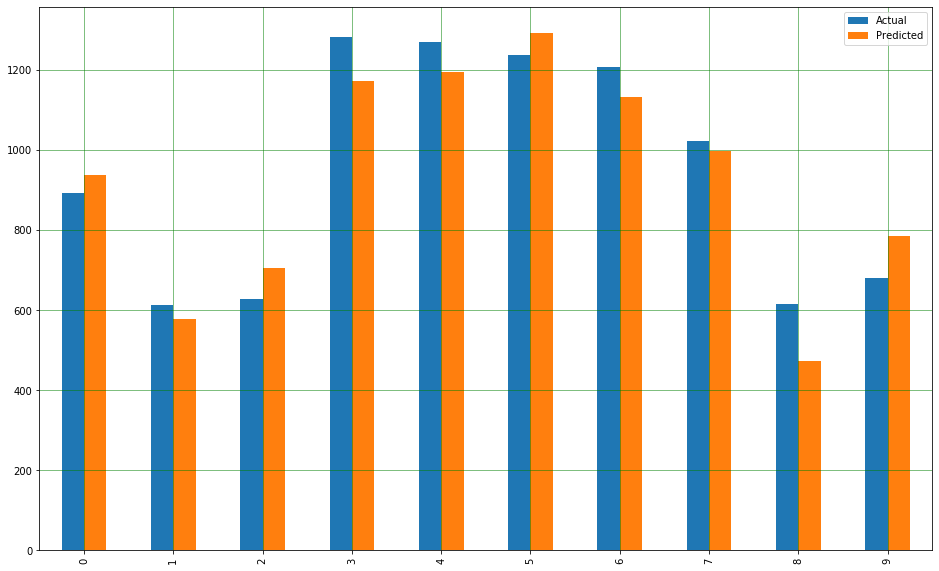

In [25]:
preds = gruDeaths.PredictTest(gruDeaths.X_test)
gruDeaths.barplot(preds)